In [24]:
import math


def leaky_relu(x: float) -> float:
    return max(0.1 * x, x)


def relu(x: float) -> float:
    return max(0, x)


def sigmoid(x: float) -> float:
    return 1 / (1 + math.exp(-1 * x))


def tanh(x: float) -> float:
    return math.tanh(x)


def elu(x: float, a: float) -> float:
    return x if x > 0 else a * (math.exp(x) - 1)

In [25]:
from pathlib import Path
import numpy as np
import numpy.typing as npt
import pandas as pd
from load_google_data import load_google_stock_data


# Define RNN with gradient calculation
class SimpleRNN:
    input_size: int
    hidden_size: int

    W_xh: npt.NDArray[np.float64]
    W_hh: npt.NDArray[np.float64]
    W_hy: npt.NDArray[np.float64]
    h: npt.NDArray[np.float64]

    def __init__(
        self,
        input_size: int,  # Length of input array
        hidden_size: int,  # Length of hidden states
    ):
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.W_xh = (
            np.random.randn(hidden_size, input_size) * 0.01
        )  # Weights from input layer to hidden layer
        self.W_hh = (
            np.random.randn(hidden_size, hidden_size) * 0.01
        )  # Weights from hidden layer to hidden layer
        self.W_hy = (
            np.random.randn(1, hidden_size) * 0.01
        )  # Weights from hidden layer to output layer
        self.h = np.zeros((hidden_size, 1))  # Initialize hidden state

    def step(self, x: npt.NDArray[np.float64]) -> float:
        x = x.reshape(-1, 1)  # Reshape to column vector
        self.h = np.tanh(
            np.dot(self.W_xh, x) + np.dot(self.W_hh, self.h)
        )  # Calculate the next hidden state
        y = elu(np.dot(self.W_hy, self.h), 2)  # Calculate the prediction for this input
        return float(y)

    def forward(self, inputs: list[npt.NDArray[np.float64]]) -> float:
        self.hs = []  # To store hidden states
        for x in inputs:
            y = self.step(x)
            self.hs.append(self.h)
        return y

    def backward(
        self,
        inputs: list[pd.Series],
        target: pd.Series,
        output: float,
        learning_rate: float = 0.01,
    ) -> None:
        # Compute gradient of the loss with respect to output
        d_loss = 2 * (output - target)  # Derivative of MSE

        # Backpropagate through the output layer
        d_W_hy = np.dot(d_loss, self.h.T)

        # Initialize hidden state gradients
        d_h = np.dot(self.W_hy.T, d_loss)
        d_W_hh = np.zeros_like(self.W_hh)
        d_W_xh = np.zeros_like(self.W_xh)

        # Backpropagate through time
        for t in reversed(range(len(inputs))):
            d_h_raw = (1 - self.hs[t] ** 2) * d_h  # Derivative of tanh
            d_W_hh += np.dot(
                d_h_raw, self.hs[t - 1].T if t > 0 else np.zeros_like(self.h).T
            )
            d_W_xh += np.dot(d_h_raw, inputs[t].T)
            d_h = np.dot(self.W_hh.T, d_h_raw)

        # Update weights
        self.W_hy -= learning_rate * d_W_hy
        self.W_hh -= learning_rate * d_W_hh
        self.W_xh -= learning_rate * d_W_xh


# Training Function
def train_rnn(
    rnn: SimpleRNN,
    train_sequences: list[tuple[pd.Series, pd.Series]],
    epochs: int = 10,
    learning_rate: float = 0.01,
) -> None:
    for epoch in range(epochs):
        losses = []
        for seq, target in train_sequences:
            rnn.h = np.zeros((rnn.hidden_size, 1))  # Reset hidden state
            inputs = [x.reshape(-1, 1) for x in seq]  # Prepare sequence as input

            prediction = rnn.forward(inputs)

            loss = (prediction - target) ** 2
            losses.append(loss)

            # Backward pass
            rnn.backward(inputs, target, prediction, learning_rate)

        loss = sum(losses) / len(losses)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")


# Create sequences for training (sequence_length is the number of past days to predict the next day)
def create_sequences(
    data: pd.DataFrame, sequence_length: int
) -> list[tuple[pd.Series, pd.Series]]:
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i : i + sequence_length, :]
        target = data[i + sequence_length, 3]  # 'Close' value as target
        sequences.append((seq, target))
    return sequences


# Test the RNN without training (predictions based on random weights)
def test_rnn(
    rnn: SimpleRNN, test_data: pd.DataFrame, sequence_length: int = 10
) -> tuple[list[float], list[float]]:
    sequences = create_sequences(test_data, sequence_length)
    predictions: list[float] = []
    targets: list[float] = []

    for seq, target in sequences:
        rnn.h = np.zeros((rnn.hidden_size, 1))  # Reset hidden state for each sequence

        for t in range(sequence_length):
            x = seq[t].reshape(-1, 1)  # Reshape to column vector (input_size, 1)
            rnn.step(x)  # Pass as a single timestep

        y_pred = np.dot(rnn.W_hy, rnn.h)  # Compute final output
        predictions.append(y_pred.ravel()[0])
        targets.append(target)

    # Calculate RMSE
    rmse = np.sqrt(np.mean((np.array(predictions) - np.array(targets)) ** 2))
    print(f"Test RMSE: {rmse:.4f}")

    return predictions, targets


# Paths to training and testing data
train_filepath = Path(
    "/mnt/c/Users/chris/OneDrive/University/2024/Deep Learning Fundamentals/assignment3/Google_Stock_Price_Train.csv"
)
test_filepath = Path(
    "/mnt/c/Users/chris/OneDrive/University/2024/Deep Learning Fundamentals/assignment3/Google_Stock_Price_Test.csv"
)


train_data = load_google_stock_data(train_filepath)
test_data = load_google_stock_data(test_filepath)

# Load and prepare data
sequence_length = 5
train_sequences = create_sequences(train_data, sequence_length)

# Initialize and train RNN
rnn = SimpleRNN(input_size=train_data.shape[1], hidden_size=50)
train_rnn(rnn, train_sequences, epochs=20, learning_rate=0.001)
# Test the RNN (no training)
predictions, targets = test_rnn(rnn, test_data, sequence_length)

/tmp/ipykernel_415146/3783682201.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return x if x > 0 else a * (math.exp(x) - 1)
/tmp/ipykernel_415146/2898277237.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(y)


Epoch 1/20, Loss: 0.2444
Epoch 2/20, Loss: 0.2037
Epoch 3/20, Loss: 0.1047
Epoch 4/20, Loss: 0.0517
Epoch 5/20, Loss: 0.0360
Epoch 6/20, Loss: 0.0255
Epoch 7/20, Loss: 0.0168
Epoch 8/20, Loss: 0.0102
Epoch 9/20, Loss: 0.0058
Epoch 10/20, Loss: 0.0034
Epoch 11/20, Loss: 0.0023
Epoch 12/20, Loss: 0.0018
Epoch 13/20, Loss: 0.0016
Epoch 14/20, Loss: 0.0016
Epoch 15/20, Loss: 0.0015
Epoch 16/20, Loss: 0.0015
Epoch 17/20, Loss: 0.0015
Epoch 18/20, Loss: 0.0015
Epoch 19/20, Loss: 0.0015
Epoch 20/20, Loss: 0.0014
Test RMSE: 0.2244


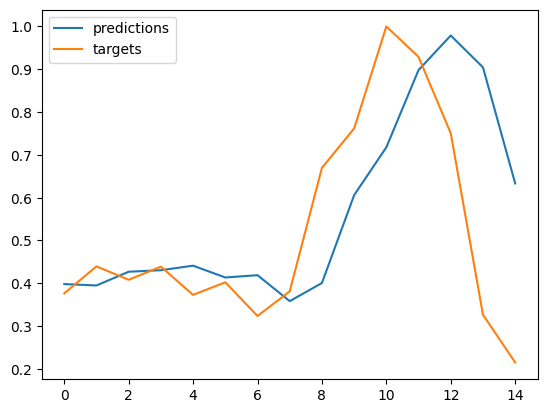

In [26]:
import matplotlib.pyplot as plt

plt.plot(predictions, label="predictions")
plt.plot(targets, label="targets")

plt.legend()
plt.show()